In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

plt.rcParams.update({'font.size': 35})

<h1>Things to compare</h1>
<div>
<ul>
  <li>l1 Comparing Measures of Sparsity</li>
  <li>l2 Comparing Measures of Sparsity</li>
  <li>l1 MEASURING SPARSENESS OF NOISY SIGNAL</li>
  <li>l2 MEASURING SPARSENESS OF NOISY SIGNAL</li>
  <li>Depending on the result choose the good one for l2/l1</li>
  <li>tanh</li>
  <li>log</li>
</ul>
</div>

In [2]:
# read all of the data
# https://github.com/mttk/STL10
plt.rcParams.update({'font.size': 35})
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [29]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.regularizer    = which_reg
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer,self.layerA
    
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.regularizer == 1: grad = grad - lamda * tf.ones_like(self.w)
        if self.regularizer == 2: grad = grad - lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-8)) * self.w
        if self.regularizer == 3: grad = grad + lamda * tf.sign(self.w)
        if self.regularizer == 4: grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-8)) * tf.abs(self.w) * tf.sign(self.w)
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        return grad_pass,grad,update_w
    
def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     

In [30]:
# set hyper parameter
plt.rcParams.update({'font.size': 35})
num_epoch = 150; learning_rate = 0.0008; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.00001

In [31]:
# 1. no reg
current_exp_name = 'none/'; current_regularizer = 0
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Train Acc : 0.11920000234246254 Test Acc : 0.1592500028759241

Current Iter : 1/150 batch : 7980/8000 acc : 0.25
 Current : 1 Train Acc : 0.16260000292956828 Test Acc : 0.1955000029504299

Current Iter : 2/150 batch : 7980/8000 acc : 0.35
 Current : 2 Train Acc : 0.20220000368356705 Test Acc : 0.23900000330992044

Current Iter : 3/150 batch : 7980/8000 acc : 0.35
 Current : 3 Train Acc : 0.23900000314414502 Test Acc : 0.26825000311248004

Current Iter : 4/150 batch : 7980/8000 acc : 0.45
 Current : 4 Train Acc : 0.2660000023692846 Test Acc : 0.3091250021569431

Current Iter : 5/150 batch : 7980/8000 acc : 0.55
 Current : 5 Train Acc : 0.28900000274181364 Test Acc : 0.3178750021662563

Current Iter : 6/150 batch : 7980/8000 acc : 0.55
 Current : 6 Train Acc : 0.2960000027269125 Test Acc : 0.31887500192970036

Current Iter : 7/150 batch : 7980/8000 acc : 0.55
 Current : 7 Train Acc : 0.30680000269412994 Test Acc : 0.325125001

Current Iter : 128/150 batch : 7980/8000 acc : 0.55
 Current : 128 Train Acc : 0.5324000015854835 Test Acc : 0.4593750010989606

Current Iter : 129/150 batch : 7980/8000 acc : 0.55
 Current : 129 Train Acc : 0.5330000030398369 Test Acc : 0.4611250010319054

Current Iter : 130/150 batch : 7980/8000 acc : 0.55
 Current : 130 Train Acc : 0.5356000028252602 Test Acc : 0.4637500014528632

Current Iter : 131/150 batch : 7980/8000 acc : 0.55
 Current : 131 Train Acc : 0.5356000012755394 Test Acc : 0.4641250018402934

Current Iter : 132/150 batch : 7980/8000 acc : 0.55
 Current : 132 Train Acc : 0.5380000013709069 Test Acc : 0.46337500140070914

Current Iter : 133/150 batch : 7980/8000 acc : 0.55
 Current : 133 Train Acc : 0.539400001347065 Test Acc : 0.46475000146776435

Current Iter : 134/150 batch : 7980/8000 acc : 0.55
 Current : 134 Train Acc : 0.5424000018239021 Test Acc : 0.466000001616776

Current Iter : 135/150 batch : 7980/8000 acc : 0.55
 Current : 135 Train Acc : 0.5438000013232231

In [32]:
# 2. l1 from c
current_exp_name = 'l1_a/'; current_regularizer = 1
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.05
 Current : 0 Train Acc : 0.11720000250637531 Test Acc : 0.12575000260956584

Current Iter : 1/150 batch : 7980/8000 acc : 0.25
 Current : 1 Train Acc : 0.17140000301599503 Test Acc : 0.1890000030491501

Current Iter : 2/150 batch : 7980/8000 acc : 0.25
 Current : 2 Train Acc : 0.20860000325739383 Test Acc : 0.259625003086403

Current Iter : 3/150 batch : 7980/8000 acc : 0.25
 Current : 3 Train Acc : 0.2518000030964613 Test Acc : 0.2847500023804605

Current Iter : 4/150 batch : 7980/8000 acc : 0.35
 Current : 4 Train Acc : 0.2730000028014183 Test Acc : 0.29675000239163635

Current Iter : 5/150 batch : 7980/8000 acc : 0.35
 Current : 5 Train Acc : 0.29620000219345094 Test Acc : 0.30675000143237413

Current Iter : 6/150 batch : 7980/8000 acc : 0.45
 Current : 6 Train Acc : 0.3074000027477741 Test Acc : 0.3242500015627593

Current Iter : 7/150 batch : 7980/8000 acc : 0.45
 Current : 7 Train Acc : 0.3204000018388033 Test Acc : 0.333750001583

Current Iter : 128/150 batch : 7980/8000 acc : 0.55
 Current : 128 Train Acc : 0.5818000024557114 Test Acc : 0.5098750011436641

Current Iter : 129/150 batch : 7980/8000 acc : 0.55
 Current : 129 Train Acc : 0.5848000024557114 Test Acc : 0.5095000009797513

Current Iter : 130/150 batch : 7980/8000 acc : 0.55
 Current : 130 Train Acc : 0.5842000027894974 Test Acc : 0.5091250012628734

Current Iter : 131/150 batch : 7980/8000 acc : 0.55
 Current : 131 Train Acc : 0.5872000029087067 Test Acc : 0.5085000013373793

Current Iter : 132/150 batch : 7980/8000 acc : 0.55
 Current : 132 Train Acc : 0.586200003862381 Test Acc : 0.5086250013113022

Current Iter : 133/150 batch : 7980/8000 acc : 0.55
 Current : 133 Train Acc : 0.5872000033855438 Test Acc : 0.5087500013411045

Current Iter : 134/150 batch : 7980/8000 acc : 0.55
 Current : 134 Train Acc : 0.5870000038146973 Test Acc : 0.508625001348555

Current Iter : 135/150 batch : 7980/8000 acc : 0.55
 Current : 135 Train Acc : 0.5888000034093857 T

In [33]:
# 3. l2 from c
current_exp_name = 'l2_a/'; current_regularizer = 2
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Train Acc : 0.1392000028192997 Test Acc : 0.1443750027474016

Current Iter : 1/150 batch : 7980/8000 acc : 0.45
 Current : 1 Train Acc : 0.21400000254809856 Test Acc : 0.2798750027175993

Current Iter : 2/150 batch : 7980/8000 acc : 0.35
 Current : 2 Train Acc : 0.27320000341534617 Test Acc : 0.2966250023432076

Current Iter : 3/150 batch : 7980/8000 acc : 0.35
 Current : 3 Train Acc : 0.29900000190734866 Test Acc : 0.3045000023953617

Current Iter : 4/150 batch : 7980/8000 acc : 0.45
 Current : 4 Train Acc : 0.31880000177025797 Test Acc : 0.31962500205263494

Current Iter : 5/150 batch : 7980/8000 acc : 0.45
 Current : 5 Train Acc : 0.3328000017106533 Test Acc : 0.3328750017378479

Current Iter : 6/150 batch : 7980/8000 acc : 0.55
 Current : 6 Train Acc : 0.34660000136494634 Test Acc : 0.3490000013913959

Current Iter : 7/150 batch : 7980/8000 acc : 0.45
 Current : 7 Train Acc : 0.35760000205039977 Test Acc : 0.35300000164

Current Iter : 128/150 batch : 7980/8000 acc : 0.55
 Current : 128 Train Acc : 0.6529999989271164 Test Acc : 0.5286250030994415

Current Iter : 129/150 batch : 7980/8000 acc : 0.55
 Current : 129 Train Acc : 0.6547999991178513 Test Acc : 0.5285000030323863

Current Iter : 130/150 batch : 7980/8000 acc : 0.55
 Current : 130 Train Acc : 0.657199998497963 Test Acc : 0.5288750031590461

Current Iter : 131/150 batch : 7980/8000 acc : 0.55
 Current : 131 Train Acc : 0.657199998497963 Test Acc : 0.5306250027567149

Current Iter : 132/150 batch : 7980/8000 acc : 0.55
 Current : 132 Train Acc : 0.6575999991893768 Test Acc : 0.5290000028908253

Current Iter : 133/150 batch : 7980/8000 acc : 0.65
 Current : 133 Train Acc : 0.6595999988317489 Test Acc : 0.5292500027641655

Current Iter : 134/150 batch : 7980/8000 acc : 0.65
 Current : 134 Train Acc : 0.6625999981164932 Test Acc : 0.5296250020340085

Current Iter : 135/150 batch : 7980/8000 acc : 0.55
 Current : 135 Train Acc : 0.666199999332428 Te

In [34]:
# 4. l1 from M
current_exp_name = 'l1_b/'; current_regularizer = 3
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.15
 Current : 0 Train Acc : 0.13640000256896018 Test Acc : 0.15525000306777656

Current Iter : 1/150 batch : 7980/8000 acc : 0.25
 Current : 1 Train Acc : 0.16140000304579735 Test Acc : 0.18450000311248005

Current Iter : 2/150 batch : 7980/8000 acc : 0.25
 Current : 2 Train Acc : 0.17800000303983687 Test Acc : 0.1927500030491501

Current Iter : 3/150 batch : 7980/8000 acc : 0.35
 Current : 3 Train Acc : 0.1900000029504299 Test Acc : 0.21975000330246985

Current Iter : 4/150 batch : 7980/8000 acc : 0.15
 Current : 4 Train Acc : 0.21180000288784503 Test Acc : 0.22387500319629908

Current Iter : 5/150 batch : 7980/8000 acc : 0.25
 Current : 5 Train Acc : 0.2248000027537346 Test Acc : 0.2497500028181821

Current Iter : 6/150 batch : 7980/8000 acc : 0.25
 Current : 6 Train Acc : 0.24740000289678574 Test Acc : 0.26612500300630926

Current Iter : 7/150 batch : 7980/8000 acc : 0.35
 Current : 7 Train Acc : 0.26480000242590906 Test Acc : 0.2808750

Current Iter : 128/150 batch : 7980/8000 acc : 0.45
 Current : 128 Train Acc : 0.5158000013381243 Test Acc : 0.4517500005289912

Current Iter : 129/150 batch : 7980/8000 acc : 0.45
 Current : 129 Train Acc : 0.5152000008374452 Test Acc : 0.453500000461936

Current Iter : 130/150 batch : 7980/8000 acc : 0.45
 Current : 130 Train Acc : 0.5150000012069941 Test Acc : 0.4537500005960464

Current Iter : 131/150 batch : 7980/8000 acc : 0.45
 Current : 131 Train Acc : 0.5164000016599893 Test Acc : 0.45400000087916853

Current Iter : 132/150 batch : 7980/8000 acc : 0.45
 Current : 132 Train Acc : 0.5202000006586314 Test Acc : 0.4546250012516975

Current Iter : 133/150 batch : 7980/8000 acc : 0.45
 Current : 133 Train Acc : 0.5190000013262034 Test Acc : 0.45450000077486036

Current Iter : 134/150 batch : 7980/8000 acc : 0.45
 Current : 134 Train Acc : 0.5198000016957521 Test Acc : 0.4578750005364418

Current Iter : 135/150 batch : 7980/8000 acc : 0.45
 Current : 135 Train Acc : 0.523200001195073

In [35]:
# 5. l2 from M
current_exp_name = 'l2_b/'; current_regularizer = 4
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Train Acc : 0.13240000261366366 Test Acc : 0.17600000320002437

Current Iter : 1/150 batch : 7980/8000 acc : 0.35
 Current : 1 Train Acc : 0.16960000324249266 Test Acc : 0.19325000327080488

Current Iter : 2/150 batch : 7980/8000 acc : 0.35
 Current : 2 Train Acc : 0.18240000335872172 Test Acc : 0.21062500326894223

Current Iter : 3/150 batch : 7980/8000 acc : 0.35
 Current : 3 Train Acc : 0.20340000374615191 Test Acc : 0.23412500316277146

Current Iter : 4/150 batch : 7980/8000 acc : 0.25
 Current : 4 Train Acc : 0.22440000316500663 Test Acc : 0.25512500331737104

Current Iter : 5/150 batch : 7980/8000 acc : 0.25
 Current : 5 Train Acc : 0.24100000357627868 Test Acc : 0.261375003028661

Current Iter : 6/150 batch : 7980/8000 acc : 0.35
 Current : 6 Train Acc : 0.24660000337660312 Test Acc : 0.26437500294297933

Current Iter : 7/150 batch : 7980/8000 acc : 0.35
 Current : 7 Train Acc : 0.25220000310242174 Test Acc : 0.26750

Current Iter : 128/150 batch : 7980/8000 acc : 0.55
 Current : 128 Train Acc : 0.5190000024437904 Test Acc : 0.46425000052899124

Current Iter : 129/150 batch : 7980/8000 acc : 0.55
 Current : 129 Train Acc : 0.5180000025629997 Test Acc : 0.46337500046938657

Current Iter : 130/150 batch : 7980/8000 acc : 0.55
 Current : 130 Train Acc : 0.5194000025391579 Test Acc : 0.4643750004097819

Current Iter : 131/150 batch : 7980/8000 acc : 0.55
 Current : 131 Train Acc : 0.5222000029683113 Test Acc : 0.46462500020861625

Current Iter : 132/150 batch : 7980/8000 acc : 0.55
 Current : 132 Train Acc : 0.5202000024914741 Test Acc : 0.46537500016391276

Current Iter : 133/150 batch : 7980/8000 acc : 0.55
 Current : 133 Train Acc : 0.5222000022530555 Test Acc : 0.46500000018626453

Current Iter : 134/150 batch : 7980/8000 acc : 0.55
 Current : 134 Train Acc : 0.5234000019431114 Test Acc : 0.4662500002980232

Current Iter : 135/150 batch : 7980/8000 acc : 0.55
 Current : 135 Train Acc : 0.52240000146

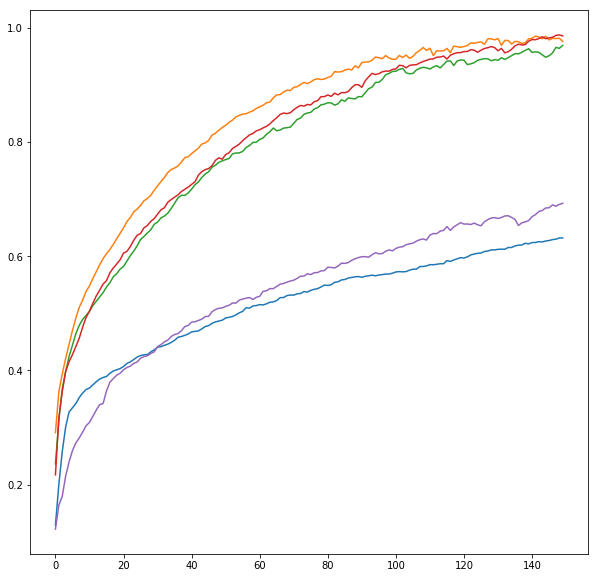

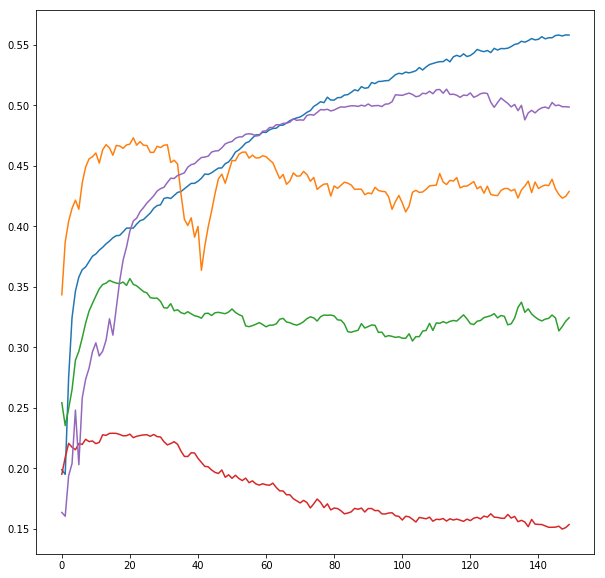

In [10]:
# read and plot all accuracy
normal = np.load('Normal/train.npy')
batch  = np.load("batch Norm/train.npy")
layer  = np.load("Layer Norm/train.npy")
instace= np.load("Instace Norm/train.npy")
boxcox = np.load("Box Cox/train.npy")

plt.figure(figsize=(10,10))
plt.plot(normal); plt.plot(batch); plt.plot(layer); plt.plot(instace); plt.plot(boxcox); 
plt.show()

normal = np.load('Normal/test.npy')
batch  = np.load("batch Norm/test.npy")
layer  = np.load("Layer Norm/test.npy")
instace= np.load("Instace Norm/test.npy")
boxcox = np.load("Box Cox/test.npy")

plt.figure(figsize=(10,10))
plt.plot(normal); plt.plot(batch); plt.plot(layer); plt.plot(instace); plt.plot(boxcox); 
plt.show()

<img src="https://i.imgur.com/kEpI4nF.png"> 

First is the histogram
Second Mean, STD, Skewness and Kurtosis 
FInally co-covariance

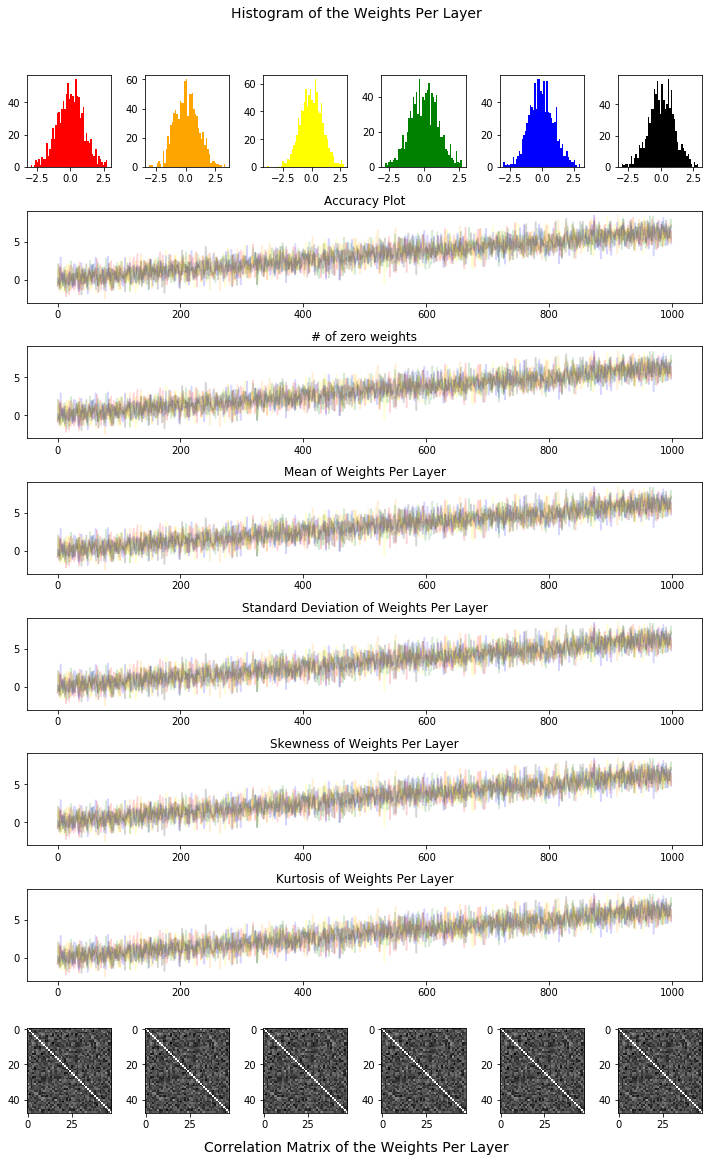

In [78]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
#  notes from: https://www.python-course.eu/matplotlib_multiple_figures.php

one,two,three,four,five,six = np.random.randn(1000),np.random.randn(1000),np.random.randn(1000),np.random.randn(1000),np.random.randn(1000),np.random.randn(1000)

X = np.linspace(0, 2 * np.pi, 1000, endpoint=True)
F1 = 2.8 * np.cos(X)
F2 = 5 * np.sin(X)
F3 = 0.3 * np.sin(X)

plt.figure(figsize=(10,15))
G = gridspec.GridSpec(8, 6)

plt.figtext(0.5,1.05,"Histogram of the Weights Per Layer",ha="center", va="top", fontsize=14, color="black")
plt.subplot(G[0, 0]).hist(one,50,color='red')
plt.subplot(G[0, 0]).hist(one,50,color='red')

plt.subplot(G[0, 1]).hist(two,50,color='orange')
plt.subplot(G[0, 2]).hist(three,50,color='yellow')
plt.subplot(G[0, 3]).hist(four,50,color='green')
plt.subplot(G[0, 4]).hist(five,50,color='blue')
plt.subplot(G[0, 5]).hist(six,50,color='black')

plt.subplot(G[1, :]).set_title("Accuracy Plot")
plt.subplot(G[1, :]).plot(X+one  ,c='red',alpha=0.1666)
plt.subplot(G[1, :]).plot(X+two  ,c='orange',alpha=0.1666)
plt.subplot(G[1, :]).plot(X+three,c='yellow',alpha=0.1666)
plt.subplot(G[1, :]).plot(X+four,c='green',alpha=0.1666)
plt.subplot(G[1, :]).plot(X+five,c='blue',alpha=0.1666)
plt.subplot(G[1, :]).plot(X+six,c='black',alpha=0.1666)

plt.subplot(G[2, :]).set_title("# of zero weights")
plt.subplot(G[2, :]).plot(X+one  ,c='red',alpha=0.1666)
plt.subplot(G[2, :]).plot(X+two  ,c='orange',alpha=0.1666)
plt.subplot(G[2, :]).plot(X+three,c='yellow',alpha=0.1666)
plt.subplot(G[2, :]).plot(X+four,c='green',alpha=0.1666)
plt.subplot(G[2, :]).plot(X+five,c='blue',alpha=0.1666)
plt.subplot(G[2, :]).plot(X+six,c='black',alpha=0.1666)

plt.subplot(G[3, :]).set_title("Mean of Weights Per Layer")
plt.subplot(G[3, :]).plot(X+one  ,c='red',alpha=0.1666)
plt.subplot(G[3, :]).plot(X+two  ,c='orange',alpha=0.1666)
plt.subplot(G[3, :]).plot(X+three,c='yellow',alpha=0.1666)
plt.subplot(G[3, :]).plot(X+four,c='green',alpha=0.1666)
plt.subplot(G[3, :]).plot(X+five,c='blue',alpha=0.1666)
plt.subplot(G[3, :]).plot(X+six,c='black',alpha=0.1666)

plt.subplot(G[4, :]).set_title("Standard Deviation of Weights Per Layer")
plt.subplot(G[4, :]).plot(X+one  ,c='red',alpha=0.1666)
plt.subplot(G[4, :]).plot(X+two  ,c='orange',alpha=0.1666)
plt.subplot(G[4, :]).plot(X+three,c='yellow',alpha=0.1666)
plt.subplot(G[4, :]).plot(X+four,c='green',alpha=0.1666)
plt.subplot(G[4, :]).plot(X+five,c='blue',alpha=0.1666)
plt.subplot(G[4, :]).plot(X+six,c='black',alpha=0.1666)

plt.subplot(G[5, :]).set_title("Skewness of Weights Per Layer")
plt.subplot(G[5, :]).plot(X+one  ,c='red',alpha=0.1666)
plt.subplot(G[5, :]).plot(X+two  ,c='orange',alpha=0.1666)
plt.subplot(G[5, :]).plot(X+three,c='yellow',alpha=0.1666)
plt.subplot(G[5, :]).plot(X+four,c='green',alpha=0.1666)
plt.subplot(G[5, :]).plot(X+five,c='blue',alpha=0.1666)
plt.subplot(G[5, :]).plot(X+six,c='black',alpha=0.1666)

plt.subplot(G[6, :]).set_title("Kurtosis of Weights Per Layer")
plt.subplot(G[6, :]).plot(X+one  ,c='red',alpha=0.1666)
plt.subplot(G[6, :]).plot(X+two  ,c='orange',alpha=0.1666)
plt.subplot(G[6, :]).plot(X+three,c='yellow',alpha=0.1666)
plt.subplot(G[6, :]).plot(X+four,c='green',alpha=0.1666)
plt.subplot(G[6, :]).plot(X+five,c='blue',alpha=0.1666)
plt.subplot(G[6, :]).plot(X+six,c='black',alpha=0.1666)

plt.figtext(0.5,0.0,"Correlation Matrix of the Weights Per Layer",ha="center", va="top", fontsize=14, color="black")
temp = np.random.randn(48,48)
plt.subplot(G[7, 0]).imshow(np.corrcoef(temp),cmap='gray')
plt.subplot(G[7, 1]).imshow(np.corrcoef(temp),cmap='gray')
plt.subplot(G[7, 2]).imshow(np.corrcoef(temp),cmap='gray')
plt.subplot(G[7, 3]).imshow(np.corrcoef(temp),cmap='gray')
plt.subplot(G[7, 4]).imshow(np.corrcoef(temp),cmap='gray')
plt.subplot(G[7, 5]).imshow(np.corrcoef(temp),cmap='gray')

plt.tight_layout()
plt.show()

In [61]:
temp = np.random.randn(10,10)
temp.shape
np.corrcoef(temp)

array([[ 1.        , -0.06489328,  0.3100802 , -0.26938426, -0.10119228,
         0.39215849,  0.17670137,  0.54858541, -0.00884577, -0.33280971],
       [-0.06489328,  1.        , -0.32074406,  0.40250456,  0.63289773,
        -0.13141991, -0.16863478, -0.51417382, -0.12292354, -0.08732921],
       [ 0.3100802 , -0.32074406,  1.        , -0.02725575, -0.39152252,
        -0.12943815, -0.01934826,  0.82036302, -0.10390385, -0.06006138],
       [-0.26938426,  0.40250456, -0.02725575,  1.        ,  0.10780961,
        -0.17563267, -0.19492179, -0.07130088,  0.05547203, -0.54776572],
       [-0.10119228,  0.63289773, -0.39152252,  0.10780961,  1.        ,
         0.34725198, -0.01475459, -0.54342363, -0.2455625 ,  0.42225091],
       [ 0.39215849, -0.13141991, -0.12943815, -0.17563267,  0.34725198,
         1.        , -0.07342801,  0.15172891,  0.17578687,  0.18089699],
       [ 0.17670137, -0.16863478, -0.01934826, -0.19492179, -0.01475459,
        -0.07342801,  1.        , -0.04099254

# Reference
1. mttk/STL10. (2018). GitHub. Retrieved 19 December 2018, from https://github.com/mttk/STL10
2. regularization?, W. (2016). Why is the penalty term added instead of subtracting it from loss term in regularization?. Cross Validated. Retrieved 26 December 2018, from https://stats.stackexchange.com/questions/236830/why-is-the-penalty-term-added-instead-of-subtracting-it-from-loss-term-in-regula
3. (2018). Bsp.brain.riken.jp. Retrieved 26 December 2018, from http://www.bsp.brain.riken.jp/publications/2003/ICA03KarvCich.pdf
4. Hurley, N., & Rickard, S. (2008). Comparing Measures of Sparsity. arXiv.org. Retrieved 26 December 2018, from https://arxiv.org/abs/0811.4706
5. Numerical & Scientific Computing with Python: Creating Subplots with Python and Matplotlib. (2018). Python-course.eu. Retrieved 31 December 2018, from https://www.python-course.eu/matplotlib_multiple_figures.php
6. plot, a. (2016). add subtitles for rows of a plot. Stack Overflow. Retrieved 2 January 2019, from https://stackoverflow.com/questions/40788403/add-subtitles-for-rows-of-a-plot/40788867
7. subplots, M. (2012). Matplotlib - global legend and title aside subplots. Stack Overflow. Retrieved 2 January 2019, from https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
8. Matplotlib?, H. (2014). How to add title to subplots in Matplotlib?. Stack Overflow. Retrieved 2 January 2019, from https://stackoverflow.com/questions/25239933/how-to-add-title-to-subplots-in-matplotlib
9. 

<a href="https://stats.stackexchange.com/questions/236830/why-is-the-penalty-term-added-instead-of-subtracting-it-from-loss-term-in-regula"> Good Derivative </a>